In [26]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from copy import copy
import seaborn
from max_binary_heap import *
%matplotlib inline 

# Define MDP
class blind_cliff_walk(object):
    """MDP for the blind cliff-walk problem
    Action space is 1/0
    Terminal State is -1
    """
    
    def __init__(self,max_state):
        self.max_state = max_state
        self.state = 0
    
    def step(self,action):

        if self.state % 2 == 0:
            if action == 1 and self.state < self.max_state-1:
                self.state = self.state + 1
                reward = 0
            elif action == 1:
                self.state = -1
                reward = 1
            elif action == 0:
                self.state = -1
                reward = 0
            else:
                print('not a valid action')
                
        else:
            if action == 0 and self.state < self.max_state -1:
                self.state = self.state + 1
                reward = 0
            elif action == 0:
                self.state = -1
                reward = 1
            elif action == 1:
                self.state = -1
                reward = 0
            else:
                print('not a valid action')
                
        return self.state,reward      

In [27]:
def get_history(size):
    """Perform all possible actions on a cliff-walk of size "size" and return
    the history as a list of lists each of wich contains <S,A,R,S'>"""
    
    actions = [seq for seq in itertools.product((0,1), repeat=size)]
    history = []
    
    for action_group in actions:
        # Get a new MDP
        mdp = blind_cliff_walk(size)
        for action in action_group:
            # Take action and record transition
            state = mdp.state
            state_prime,reward = mdp.step(action)
            history.append([state,action,reward,state_prime])
            if state_prime == -1:
                mdp.state = 0
                break
    return history

[ 0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1]
[ 0.08333333  0.16666667  0.25        0.33333333  0.41666667  0.66666667
  0.75        0.83333333  0.91666667  1.        ]
[ 0.08333333  0.08333333  0.08333333  0.08333333  0.08333333  0.25
  0.08333333  0.08333333  0.08333333  0.08333333]


(array([  805.,   890.,   787.,   901.,   828.,  2514.,   853.,   817.,
          781.,   824.]),
 array([ 0. ,  0.9,  1.8,  2.7,  3.6,  4.5,  5.4,  6.3,  7.2,  8.1,  9. ]),
 <a list of 10 Patch objects>)

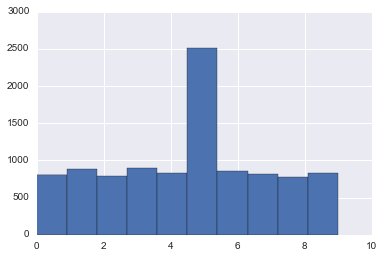

In [28]:
class discrete_distribution(object):
    """ Discrete probability distribuiton on the range [1,N]
    """
    
    def __init__(self,probs):
        """Probs is a np array of probabilites"""
        probs = np.abs(probs)
        self.Z = float(np.sum(probs))
        self.probs = probs/self.Z
        self.cumsum = np.cumsum(self.probs)
    
    def probability(self,index):
        return self.probs[index]
    
    def sample(self):
        seed = np.random.random()
        smp = 0
        while(seed > self.cumsum[smp]):
            smp = smp + 1
        return smp
    
    def update_prob(self,index,prob):
        prob = np.abs(prob)
        self.probs = self.probs*self.Z
        self.Z = self.Z - self.probs[index] + prob
        self.probs[index] = prob
        self.probs = self.probs/float(self.Z)
        self.cumsum = np.cumsum(self.probs)

x = discrete_distribution(np.ones(10))
print(x.probs)


x.update_prob(5,-3)
print(x.cumsum)
print(x.probs)
draws = []

for i in range(10000):
    draws.append(x.sample())
plt.hist(draws)
    

In [29]:
def Q(state,action,theta):
    
    if state == -1:
        return 0
    else:
        size = np.size(theta)/2
        if action == 0:
            return theta[state]
        else:
            return theta[state + size]

def get_max_action(state,theta):
    size = np.size(theta)/2
    if theta[state] > theta[state + size]:
        return 0
    else:
        return 1
    
def get_ground_truth(size):
    """ Returns the optimal action value function
    for the bcf model of size 'size' """
    
    discounts = [(1-1.0/size)**(x) for x in range(size)][::-1]
    discounts = discounts + discounts
    left_actions = [m %2 for m in range(size)]
    right_actions = copy(left_actions[1:])
    right_actions.append((right_actions[-1]+1)%2)
    
    gt = left_actions + right_actions
    
    gt = [x*y for x,y in zip(gt,discounts)]
    
    return gt

def mean_sq_er(ground_truth,theta):
    size = np.size(theta)/2.0
    return (((ground_truth - theta).sum())**2)/size


In [48]:


def experience_replay_bcf(size,rate,tol,theta_init):
    """ Perform Q-Learning on the blind cliff walk MDP
    with experience replay"""
    
    # Create Store for Thetas
    thetas = []
    errors = []
    error = 10
    count = 0
    
    # Get History
    history = get_history(size)
    
    # Initialise discount and theta
    theta = theta_init.copy()
    theta_true = get_ground_truth(size)
    gamma = 1 - 1.0/size
    
    #perform SGD/Q-learning
    while(error > tol and count < 100*(2**size)):
        #Sample transition
        index = np.random.randint(np.shape(history)[0])
        state,action,reward,state_prime = history[index]
        # Calcualte TD-error
        Q_1 = Q(state,action,theta)
        action_max = get_max_action(state_prime,theta)
        Q_prime = Q(state_prime,action_max,theta)
        delta = (reward + gamma*Q_prime - Q_1)
        #Updtate Theta
        if action == 0:
            theta[state] = theta[state] + rate*delta
        elif action == 1:
            theta[state + size] = theta[state + size] + rate*delta
        error = mean_sq_er(theta_true,theta)
        thetas.append(theta)
        errors.append(error)
        count = count + 1
        
    return thetas,errors,count


def greedy_experience_replay_bcf(size,rate,tol,theta_init):
    """ Perform Q-Learning on the blind cliff walk MDP
    with experience replay"""
    
    # Create Store for Thetas and deltas and errors
    delta_store = max_binary_heap()
    thetas = []
    errors = []
    error = 10
    count = 0
    
    # Get History
    history = get_history(size)
    np.random.shuffle(history)
    priorities = [100]*len(history)
    
    for i in range(len(history)):
        delta_store.insert(priorities[i],i)
    
    # Initialise discount and theta and theta_true
    theta = theta_init.copy()
    gamma = 1 - 1.0/size
    theta_true = get_ground_truth(size)
    
    #perform SGD/Q-learning
    while(error > tol and count < (100*2**size)):
        #Sample transition
        index = delta_store.get_max()[2]
        #print(index)
        state,action,reward,state_prime = history[index]
        # Calcualte TD-error
        Q_1 = Q(state,action,theta)
        action_max = get_max_action(state_prime,theta)
        Q_prime = Q(state_prime,action_max,theta)
        delta = (reward + gamma*Q_prime - Q_1)
        #Update Priorities
        delta_store.insert(delta,index)
        #Updtate Theta
        if action == 0:
            theta[state] = theta[state] + rate*delta
        elif action == 1:
            theta[state + size] = theta[state + size] + rate*delta
        error = mean_sq_er(theta_true,theta)
        thetas.append(theta)
        errors.append(error)
        count = count + 1
    return thetas,errors,count

def prop_experience_replay(size,rate,tol,theta_init):
    
    # Create Store for Thetas and deltas and errors
    
    thetas = []
    errors = []
    error = 10
    count = 0
    
    # Get History
    history = get_history(size)
    np.random.shuffle(history)
    priorities = np.ones(len(history))
    delta_dist = discrete_distribution(priorities)
    
    # Initialise discount and theta and theta_true
    theta = theta_init.copy()
    gamma = 1 - 1.0/size
    theta_true = get_ground_truth(size)
    
    while(error > tol and count < (100*2**size)):
        # Sample a transition
        index = delta_dist.sample()
        state,action,reward,state_prime = history[index]
        #Calculate Importance Weight
        weight = 1.0/(2*size*delta_dist.probability(index))
        #Compute the TD-Error
        Q_1 = Q(state,action,theta)
        action_max = get_max_action(state_prime,theta)
        Q_prime = Q(state_prime,action_max,theta)
        delta = (reward + gamma*Q_prime - Q_1)
        #Update theta
        if action == 0:
            theta[state] = theta[state] + rate*delta
        elif action == 1:
            theta[state + size] = theta[state + size] + rate*delta   
        # Update probability distribution
        delta_dist.update_prob(index,abs(delta))
        # Calculate errors and store 
        error = mean_sq_er(theta_true,theta)
        thetas.append(theta)
        errors.append(error)
        count = count + 1
        
    return thetas,errors,count
    
    

In [31]:

size = 10
import time
time1 = time.time()
theta_init = np.random.normal(0,0.1,size*2)
#thetas,mse_gr,count1 = greedy_experience_replay_bcf(size,0.25,0.01,theta_init)
thetas2,mse,count2 = experience_replay_bcf(size,0.25,0.01,theta_init)
thetas3,mse_prop,delta_dist = prop_experience_replay(size,0.25,0.01,theta_init)
print(time.time() - time1)

36.7150771618


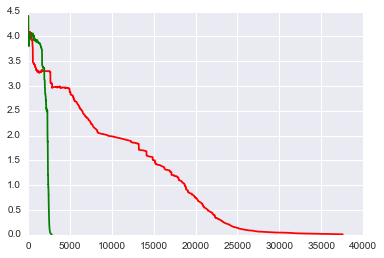

0.0099934742514927975

In [34]:
#plt.plot(mse_gr,c = 'b')
plt.plot(mse,c = 'r')
plt.plot(mse_prop,c='g')
plt.show()
mse_prop[-1]

In [51]:
# Calculate the number of iterations to converge to MSE 1e-3 for prop and Non-Greedy Experience Replay

experiments_pr = []
experiments_vn = []

for size in range(10):
    size = size + 2
    theta_init = np.random.normal(0,0.1,size*2)
    counts_pr = []
    counts_vn = []
    for exper in range(10):
        print("------------ Running Experiment {} of Size {}---------------".format(exper,size))
        
        _,_,countpr = prop_experience_replay(size,0.25,0.01,theta_init)
        _,_,countvn = experience_replay_bcf(size,0.25,0.01,theta_init)
        counts_pr.append(countpr)
        counts_vn.append(countvn)
    
    experiments_pr.append(counts_pr)
    experiments_vn.append(counts_vn)
        
        


------------ Running Experiment 0 of Size 2---------------
------------ Running Experiment 1 of Size 2---------------
------------ Running Experiment 2 of Size 2---------------
------------ Running Experiment 3 of Size 2---------------
------------ Running Experiment 4 of Size 2---------------
------------ Running Experiment 5 of Size 2---------------
------------ Running Experiment 6 of Size 2---------------
------------ Running Experiment 7 of Size 2---------------
------------ Running Experiment 8 of Size 2---------------
------------ Running Experiment 9 of Size 2---------------
------------ Running Experiment 0 of Size 3---------------
------------ Running Experiment 1 of Size 3---------------
------------ Running Experiment 2 of Size 3---------------
------------ Running Experiment 3 of Size 3---------------
------------ Running Experiment 4 of Size 3---------------
------------ Running Experiment 5 of Size 3---------------
------------ Running Experiment 6 of Size 3-------------

KeyboardInterrupt: 

In [61]:
print(len(experiments_vn))
print(experiments_pr)

9
[[30, 28, 30, 28, 30, 27, 29, 27, 24, 31], [67, 70, 64, 60, 64, 73, 62, 82, 57, 64], [123, 143, 126, 118, 130, 136, 149, 131, 128, 124], [232, 216, 189, 204, 199, 205, 221, 201, 199, 238], [392, 401, 320, 365, 360, 349, 363, 340, 357, 342], [565, 608, 609, 563, 573, 544, 545, 635, 572, 612], [923, 1010, 1062, 996, 977, 1005, 1025, 937, 1062, 1081], [1455, 1461, 1402, 1644, 1459, 1402, 1442, 1432, 1483, 1512], [2764, 2666, 2797, 2666, 2703, 2654, 2629, 2765, 2704, 2860]]


In [12]:
experiments = [[63, 52, 59, 45, 66, 80, 61, 53, 88, 62], [185, 159, 171, 137, 104, 143, 121, 107, 167, 132], [411, 331, 493, 291, 417, 367, 328, 436, 408, 309], [930, 585, 820, 741, 348, 779, 602, 576, 927, 910], [2122, 1813, 1748, 2420, 1993, 1812, 2038, 1476, 1588, 2329], [3116, 3089, 3894, 3174, 4014, 2912, 4628, 3891, 3146, 2965], [6239, 5728, 8671, 8411, 5574, 5636, 5413, 5356, 5598, 7223], [19504, 18574, 15483, 19439, 14643, 15835, 13749, 17218, 12703, 15885], [36644, 36865, 26655, 33464, 27443, 31275, 32119, 25651, 25570, 34765]]
experiments_gr = [[25, 25, 25, 25, 25, 25, 25, 25, 25, 25], [53, 54, 54, 54, 54, 54, 54, 54, 54, 54], [82, 84, 181, 82, 82, 114, 84, 106, 1600, 83], [3200, 129, 3200, 3200, 3200, 161, 3200, 3200, 3200, 133], [6400, 217, 6400, 276, 221, 276, 6400, 305, 6400, 269], [12800, 12800, 417, 12800, 12800, 12800, 12800, 12800, 12800, 12800], [25600, 25600, 25600, 25600, 25600, 25600, 25600, 25600, 25600, 25600], [51200, 51200, 51200, 51200, 51200, 51200, 51200, 51200, 51200, 51200], [102400, 102400, 102400, 102400, 102400, 102400, 102400, 102400, 102400, 102400]]

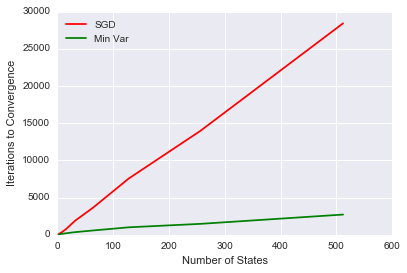

In [67]:
y_vn = [np.mean(alist) for alist in experiments_vn]
y_pr = [np.mean(alist) for alist in experiments_pr ]
x = [2**(i+1) for i in range(len(experiments_vn))]
vn, = plt.plot(x,y_vn,c = 'r')
pr, = plt.plot(x,y_pr, c = 'g')
plt.xlabel('Number of States')
plt.ylabel('Iterations to Convergence')
plt.legend([vn,pr],['SGD','Min Var'],loc =2)

[25, 97, 281, 551, 1575, 1600, 7318]

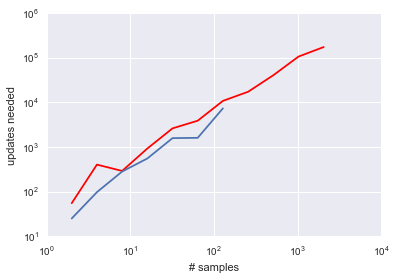

In [129]:
y1 = [55,402,290,921,2606,3868,10758,17212,40372,105712,172894]
y2 = counts
x = [2**(x+1) for x in range(11)]
plt.loglog(x,y1,c='r')
plt.loglog(x[:7],y2)
plt.ylabel('updates needed')
plt.xlabel('# samples')
counts

In [5]:
# Create Store for Thetas and deltas
delta_store = priority_queue()
thetas = np.zeros((10*2))

# Get History
history = get_history(5)
priorities = [100]*len(history)
delta_store.build_queue(range(len(history)),priorities)

In [5]:
x = [1,2,3,4]
float(sum(x))

10.0

In [4]:
type(3.0)

float

In [12]:
x = np.array([3,4,5])

3

ValueError: incompatible sizes: argument 'height' must be length 62 or scalar

> /usr/local/lib/python2.7/site-packages/matplotlib/axes/_axes.py(2080)bar()
   2079             raise ValueError("incompatible sizes: argument 'height' "
-> 2080                               "must be length %d or scalar" % nbars)
   2081         if len(width) != nbars:


KeyboardInterrupt


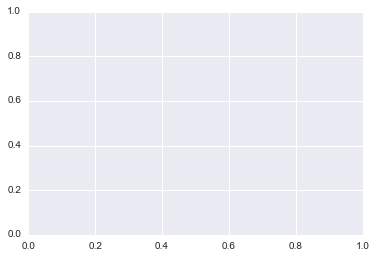

In [200]:
plt.bar(range(62),delta_dist.probs)

In [153]:

np.shape(delta_dist.probs)

(62,)

In [151]:
plt.hist?

In [224]:
x = [3,4,5,3]
np.random.shuffle(x)
x

[3, 5, 3, 4]

In [231]:
[3,5,3,4] is x

False

In [247]:
import pickle

experiments = [[63, 52, 59, 45, 66, 80, 61, 53, 88, 62], [185, 159, 171, 137, 104, 143, 121, 107, 167, 132], [411, 331, 493, 291, 417, 367, 328, 436, 408, 309], [930, 585, 820, 741, 348, 779, 602, 576, 927, 910], [2122, 1813, 1748, 2420, 1993, 1812, 2038, 1476, 1588, 2329], [3116, 3089, 3894, 3174, 4014, 2912, 4628, 3891, 3146, 2965], [6239, 5728, 8671, 8411, 5574, 5636, 5413, 5356, 5598, 7223], [19504, 18574, 15483, 19439, 14643, 15835, 13749, 17218, 12703, 15885], [36644, 36865, 26655, 33464, 27443, 31275, 32119, 25651, 25570, 34765]]
experiments_gr = [[25, 25, 25, 25, 25, 25, 25, 25, 25, 25], [53, 54, 54, 54, 54, 54, 54, 54, 54, 54], [82, 84, 181, 82, 82, 114, 84, 106, 1600, 83], [3200, 129, 3200, 3200, 3200, 161, 3200, 3200, 3200, 133], [6400, 217, 6400, 276, 221, 276, 6400, 305, 6400, 269], [12800, 12800, 417, 12800, 12800, 12800, 12800, 12800, 12800, 12800], [25600, 25600, 25600, 25600, 25600, 25600, 25600, 25600, 25600, 25600], [51200, 51200, 51200, 51200, 51200, 51200, 51200, 51200, 51200, 51200], [102400, 102400, 102400, 102400, 102400, 102400, 102400, 102400, 102400, 102400]]
with open('ExperimentResults','w') as f:
    pickle.dump(experiments,f)
    pickle.dump(experiments_gr,f)

In [244]:
f = open('ExperimentResults')



[[63, 52, 59, 45, 66, 80, 61, 53, 88, 62],
 [185, 159, 171, 137, 104, 143, 121, 107, 167, 132],
 [411, 331, 493, 291, 417, 367, 328, 436, 408, 309],
 [930, 585, 820, 741, 348, 779, 602, 576, 927, 910],
 [2122, 1813, 1748, 2420, 1993, 1812, 2038, 1476, 1588, 2329],
 [3116, 3089, 3894, 3174, 4014, 2912, 4628, 3891, 3146, 2965],
 [6239, 5728, 8671, 8411, 5574, 5636, 5413, 5356, 5598, 7223],
 [19504, 18574, 15483, 19439, 14643, 15835, 13749, 17218, 12703, 15885],
 [36644, 36865, 26655, 33464, 27443, 31275, 32119, 25651, 25570, 34765]]

In [4]:
float(5)/3

1.6666666666666667

In [9]:
import numpy as np

In [11]:
np.random.rand()

0.9608752295384204

In [114]:
np.ones(len(history))

NameError: name 'history' is not defined

> <ipython-input-114-5e467b2ddcd1>(1)<module>()
----> 1 np.ones(len(history))


KeyboardInterrupt


In [14]:
x

[1, 2, 4, 8, 16, 32, 64, 128, 256, 512]

In [19]:
y_non_greedy

[45, 104, 291, 348, 1476, 2912, 5356, 12703, 25570]

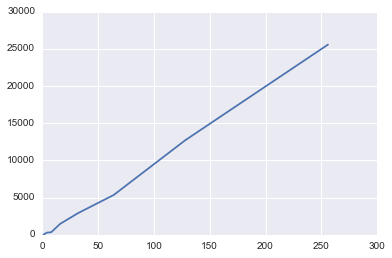

In [23]:
plt.plot(x[:-1],y_non_greedy)

In [22]:
np.shape(y_non_greedy)

(9,)